In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

2023-05-19 14:55:44.668867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 14:55:46.138093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data = np.load('../data/npy/channel_flow.npy')

# init model & load data
data_path = '../data/npy/channel_flow.npy'
model_path = '../model/fluid/'
result_path = '../result/fluid/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=4)

In [4]:
phi_tot = tf.expand_dims(data, axis=3)
new_phi = phi_tot[:490]
print(np.shape(new_phi))
phi_test = phi_tot[490:]

2023-05-19 14:57:38.721342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 14:57:38.722398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(490, 511, 127, 1)


2023-05-19 14:57:38.727264: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129794000 exceeds 10% of free system memory.
2023-05-19 14:57:39.026729: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 127198120 exceeds 10% of free system memory.


In [5]:

y = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

2023-05-19 14:57:43.843795: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32112640 exceeds 10% of free system memory.


tf.Tensor([490 256  64   1], shape=(4,), dtype=int32)


In [6]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, y,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True),
            verbose=2)

    return history



In [8]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(256,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((256, 64, 1)),
    # tf.keras.layers.UpSampling2D((2,2)),
    # tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(new_phi.shape[1:]))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) #+ NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 511, 127, 1)]     0         
                                                                 
 average_pooling2d_1 (Averag  (None, 256, 64, 1)       0         
 ePooling2D)                                                     
                                                                 
 sequential_1 (Sequential)   (None, 256, 64, 1)        2400      
                                                                 
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-05-19 14:59:49.604735: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 114478308 exceeds 10% of free system memory.


14/14 - 3s - loss: 0.4937 - mean_absolute_error: 0.6530 - val_loss: 0.4492 - val_mean_absolute_error: 0.6238 - 3s/epoch - 183ms/step
Epoch 2/500
14/14 - 1s - loss: 0.4168 - mean_absolute_error: 0.5931 - val_loss: 0.3673 - val_mean_absolute_error: 0.5426 - 708ms/epoch - 51ms/step
Epoch 3/500
14/14 - 1s - loss: 0.3215 - mean_absolute_error: 0.4897 - val_loss: 0.2672 - val_mean_absolute_error: 0.4297 - 546ms/epoch - 39ms/step
Epoch 4/500
14/14 - 1s - loss: 0.2276 - mean_absolute_error: 0.3836 - val_loss: 0.1832 - val_mean_absolute_error: 0.3311 - 513ms/epoch - 37ms/step
Epoch 5/500
14/14 - 0s - loss: 0.1531 - mean_absolute_error: 0.2932 - val_loss: 0.1204 - val_mean_absolute_error: 0.2512 - 493ms/epoch - 35ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0991 - mean_absolute_error: 0.2213 - val_loss: 0.0763 - val_mean_absolute_error: 0.1889 - 478ms/epoch - 34ms/step
Epoch 7/500
14/14 - 1s - loss: 0.0619 - mean_absolute_error: 0.1661 - val_loss: 0.0469 - val_mean_absolute_error: 0.1422 - 543ms/epo

In [9]:
test_true = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(phi_test)
test_model = history.model.predict(phi_test)

1/1 [==============================] - 0s 142ms/step


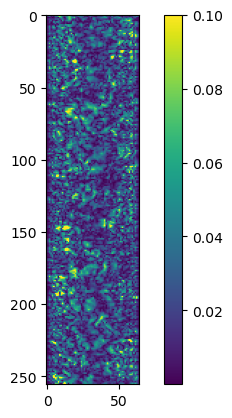

In [10]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]),vmax=0.1)
plt.colorbar()

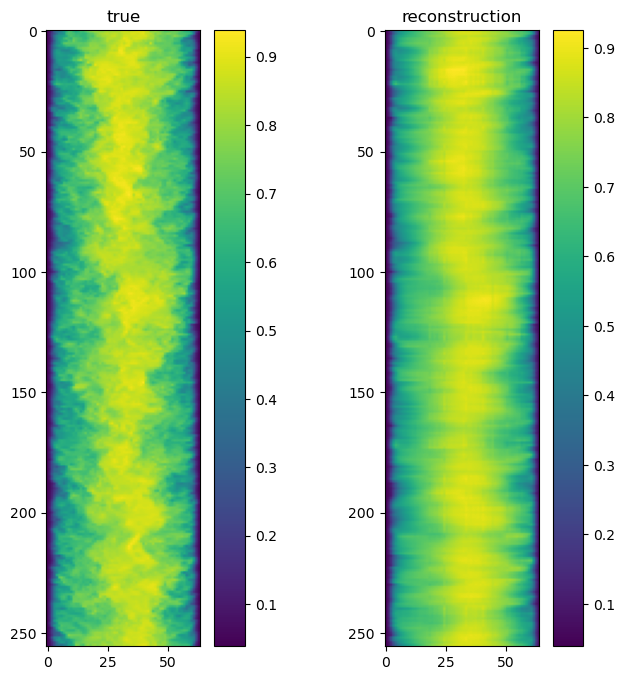

In [13]:
ind = -1
fig,axs = plt.subplots(1,2,figsize=(8,8))
im = axs[0].imshow(test_true[ind])
axs[0].set_title('true')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(test_model[ind])
axs[1].set_title('reconstruction')
plt.colorbar(im, ax=axs[1])

In [12]:
print(test_model[-1])

[[[0.04042811]
  [0.08154625]
  [0.17417786]
  ...
  [0.374583  ]
  [0.17607385]
  [0.07286155]]

 [[0.04012673]
  [0.07615481]
  [0.156532  ]
  ...
  [0.3991534 ]
  [0.18534315]
  [0.07510056]]

 [[0.0411748 ]
  [0.09287877]
  [0.21258636]
  ...
  [0.20619485]
  [0.1047901 ]
  [0.05620003]]

 ...

 [[0.04164381]
  [0.10313221]
  [0.24470149]
  ...
  [0.4013883 ]
  [0.19320858]
  [0.07632162]]

 [[0.04012   ]
  [0.0761371 ]
  [0.15547366]
  ...
  [0.37259173]
  [0.17572135]
  [0.07255547]]

 [[0.03996079]
  [0.07451919]
  [0.14952941]
  ...
  [0.34283698]
  [0.1638852 ]
  [0.0698284 ]]]
